# **Fake News Detection using BLSTM**

**The CSV contains these columns:**

* id — unique id
* title — short headline
* author — generated author name
* date — publish date (YYYY-MM-DD)
category — topic category (Politics, Science, …)
* text — article body (several sentences)
* label — target (0 = REAL, 1 = FAKE)


**Install / import libraries**

In [1]:
# Cell 1: Install (Colab only) and import libraries
# What: Ensure we have necessary libraries. In Colab you can run the pip install line;
# Why: TensorFlow, pandas, sklearn and matplotlib are needed for modeling, data handling and plots.

# (Uncomment the next line if running in Colab; in local Jupyter you can skip if packages already installed)
# !pip install --quiet tensorflow==2.12.0 pandas scikit-learn matplotlib seaborn

# Imports
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility: set seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


**Load the CSV dataset**

In [2]:
# Cell 2: Upload & Load the dataset CSV
# What: Upload the CSV file manually in Colab and load into a pandas DataFrame.
# Why: This makes the notebook portable—no need to hardcode paths. You can always re-upload the file.

from google.colab import files
import io

# Prompt user to upload file (choose fake_news_3000.csv from local machine)
uploaded = files.upload()

# Get the uploaded filename (assumes only one file uploaded)
filename = list(uploaded.keys())[0]

# Read into pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Show dataset info
print("Dataset shape:", df.shape)
print("Label distribution:\n", df['label'].value_counts())
df.head(3)


Saving fake_news_detection_dataset.csv to fake_news_detection_dataset.csv
Dataset shape: (3000, 7)
Label distribution:
 label
1    1500
0    1500
Name: count, dtype: int64


,id,title,author,date,category,text,label
0,1802,This trick will make you rich overnight,Vikram Jones,2021-09-05,Entertainment,Breaking: secret nano-pills reverse aging over...,1
1,1191,Government announces new support for small ent...,Emily Patel,2023-05-16,Technology,Scientists discovered a new method to increase...,0
2,1818,How to double money with one strange hack,Priya Verma,2018-12-26,Sports,Post claims the moon is hollow and used as a b...,1


**EDA (Explorartory data analysis)**

In [3]:
# Cell 3: Quick exploratory data analysis (EDA)
# What: Check for missing values, inspect example texts & label balance.
# Why: Ensures data is clean and balanced before training.

# Check missing values
print("Missing values per column:\n", df.isnull().sum())

# Show sample fake and real articles (first 2 each)
print("\n--- Sample REAL ---")
print(df[df['label']==0].head(2)[['title','author','date','category','text']].to_string(index=False))
print("\n--- Sample FAKE ---")
print(df[df['label']==1].head(2)[['title','author','date','category','text']].to_string(index=False))


Missing values per column:
 id          0
title       0
author      0
date        0
category    0
text        0
label       0
dtype: int64

--- Sample REAL ---
                                                 title      author       date   category                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         text
Government announces new support for small enterprises Emily Patel 2023-05-16 Technology Scientists discovered a new method to increase battery longevity by optimizing chemistry. Doctors recommend regular checkups and a balanced diet to improve public health

**Text cleaning**

In [4]:
# Cell 4: Clean text (basic normalization)
# What: Lowercasing and removing undesirable characters; combine title + body to make full input.
# Why: Cleaner input helps tokenizer produce consistent tokens and reduce noise.

def clean_text(s):
    s = str(s).lower()                     # lowercase
    s = re.sub(r'\s+', ' ', s)             # collapse whitespace
    s = re.sub(r'[^a-z0-9\s\.\,\!\?]', '', s)  # remove unusual symbols (retain basic punctuation)
    return s.strip()

# Combine title + text -> input_text
df['input_text'] = (df['title'].fillna('') + ". " + df['text'].fillna('')).apply(clean_text)
print(df['input_text'].iloc[0][:400])  # show first 400 chars of first sample


this trick will make you rich overnight. breaking secret nanopills reverse aging overnight  insiders confirm. unbelievable eating this fruit will cure all chronic diseases, says unknown blog. viral video shows politician cloned in a lab footage goes viral with millions of views. the team celebrated a narrow victory after an intense and competitive match. new law supposedly forces citizens to repla


**Tokenization and padding**

In [5]:
# Cell 5: Tokenize and pad sequences
# What: Convert text to integer token sequences using Keras Tokenizer and pad to fixed length.
# Why: Neural networks need fixed-length numeric input. Tokenizer builds vocabulary and maps words to indices.

MAX_WORDS = 15000    # keep top 15k words (vocab size)
MAX_LEN = 300        # limit each article to 300 tokens (truncate longer, pad shorter)
EMBED_DIM = 128      # embedding dimension for word vectors

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['input_text'].values)   # build vocabulary on entire dataset

sequences = tokenizer.texts_to_sequences(df['input_text'].values)
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y = df['label'].values

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (3000, 300) y shape: (3000,)


**Train/test split**

In [6]:
# Cell 6: Split data into train and test sets
# What: Use sklearn's train_test_split to create training and test sets.
# Why: Evaluate model on unseen test data to measure generalization.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (2400, 300) Test size: (600, 300)


**Build BLSTM model**

In [7]:
# Cell 7: Build the BLSTM model architecture
# What: Create a small Bidirectional LSTM network with embedding and dropout for regularization.
# Why: BLSTM captures context from both past and future tokens in the sequence (helps text tasks).

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=True)),  # returns sequence for next LSTM layer
    Dropout(0.4),                                      # helps prevent overfitting
    Bidirectional(LSTM(64)),                           # final sequence representation
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')                    # binary output: probability of FAKE
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Train model with callbacks**

In [8]:
# Cell 8: Train the model with EarlyStopping and ModelCheckpoint
# What: Fit the model on training data and validate on a split of it. Callbacks will save best model and stop early.
# Why: EarlyStopping avoids wasting time on overfitting; ModelCheckpoint saves best weights.

EPOCHS = 8
BATCH_SIZE = 64

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_blstm_fake_news.h5", monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.15,    # small portion of train reserved for validation during training
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7605 - loss: 0.4663
Epoch 1: val_loss improved from inf to 0.00223, saving model to best_blstm_fake_news.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.7648 - loss: 0.4596 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 2/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 2: val_loss improved from 0.00223 to 0.00017, saving model to best_blstm_fake_news.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 1.7308e-04
Epoch 3/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 6.7063e-04
Epoch 3: val_loss improved from 0.00017 to 0.00006, saving model to best_blstm_fake_news.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - loss: 6.6673e-04 - val_accuracy: 1.0000 - val_loss: 6.4844e-05
Epoch 4/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 3.1250e-04
Epoch 4: val_loss improved from 0.00006 to 0.00004, saving model to best_blstm_fake_news.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 1.0000 - loss: 3.1148e-04 - val_accuracy: 1.0000 - val_loss: 3.6976e-05
Epoch 5/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 2.0437e-04
Epoch 5: val_loss improved from 0.00004 to 0.00002, saving model to best_blstm_fake_news.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 2.0385e-04 - val_accuracy: 1.0000 - val_loss: 2.3972e-05
Epoch 6/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 1.4422e-04
Epoch 6: val_loss improved from 0.00002 to 0.00002, saving model to best_blstm_fake_news.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 1.0000 - loss: 1.4383e-04 - val_accuracy: 1.0000 - val_loss: 1.6651e-05
Epoch 7/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 1.1538e-04
Epoch 7: val_loss improved from 0.00002 to 0.00001, saving model to best_blstm_fake_news.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 1.0000 - loss: 1.1542e-04 - val_accuracy: 1.0000 - val_loss: 1.1872e-05
Epoch 8/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 8.2194e-05
Epoch 8: val_loss improved from 0.00001 to 0.00001, saving model to best_blstm_fake_news.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 1.0000 - loss: 8.2265e-05 - val_accuracy: 1.0000 - val_loss: 8.8594e-06
Restoring model weights from the end of the best epoch: 8.


**Evaluate model & show metrics**

Test Loss: 0.0000  Test Accuracy: 100.00%
              precision    recall  f1-score   support

        REAL       1.00      1.00      1.00       300
        FAKE       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



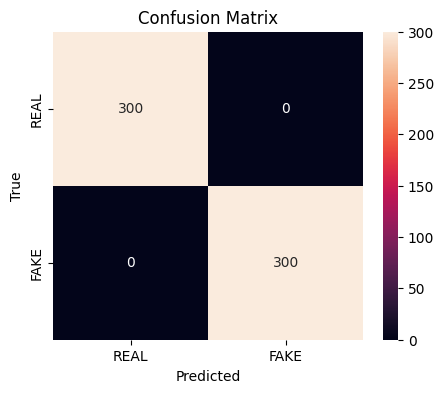

In [9]:
# Cell 9: Evaluate on test set and show classification report
# What: Load best weights (if saved) and compute accuracy, precision, recall, f1.
# Why: Per-class metrics and confusion matrix give more insight than raw accuracy.

# (Optional) load saved best weights
if os.path.exists("best_blstm_fake_news.h5"):
    model.load_weights("best_blstm_fake_news.h5")

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}  Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = (y_pred_probs.flatten() > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred, target_names=["REAL","FAKE"]))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["REAL","FAKE"], yticklabels=["REAL","FAKE"])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()


**Plot training curves**

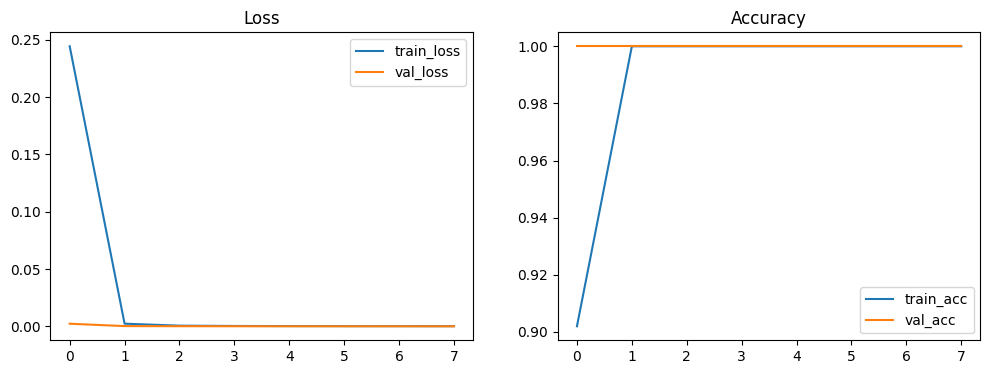

In [10]:
# Cell 10: Plot training & validation loss/accuracy curves
# What: Visualize model learning over epochs.
# Why: Helps diagnose overfitting or underfitting.

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


**Save tokenizer & helper predict function**

In [11]:
# Cell 11: Save tokenizer and provide a helper function for single-text inference
# What: Store tokenizer configuration to JSON and define predict_text() for easy testing.
# Why: Saving tokenizer ensures you can preprocess new texts the same way when deploying or reloading model.

# Save tokenizer to JSON
token_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(token_json)
print("Tokenizer saved to tokenizer.json")

# Helper
def predict_text(text, model, tokenizer, max_len=MAX_LEN):
    """
    Predict label for a single raw text string.
    Returns (label_str, probability)
    """
    t = re.sub(r'\s+', ' ', str(text).lower()).strip()
    seq = tokenizer.texts_to_sequences([t])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    prob = float(model.predict(pad)[0][0])
    label = "FAKE" if prob > 0.5 else "REAL"
    return label, prob

# Example
print(predict_text("Breaking: Scientists discovered a cure that defies biology, claims unknown blog.", model, tokenizer))


Tokenizer saved to tokenizer.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
('FAKE', 0.9999924898147583)


**Save model & dataset for download / git**

In [15]:
# Cell 12: Save final model and dataset files
# What: Save model (HDF5) and also keep a copy of the uploaded dataset file.
# Why: These files are needed for pushing to GitHub or sharing with others.

# Save BLSTM model
MODEL_PATH = "blstm_fake_news_model.h5"
model.save(MODEL_PATH)
print("✅ Model saved to", MODEL_PATH)

# Save dataset again (to ensure correct format + location)
DATASET_PATH = "fake_news_detection_dataset.csv"
df.to_csv(DATASET_PATH, index=False)
print("✅ Dataset saved to", DATASET_PATH)

# If running in Colab:
# - Use the left Files tab to download
# - OR run: from google.colab import files; files.download("fake_news_3000.csv")
#   to download directly.


✅ Model saved to blstm_fake_news_model.h5
✅ Dataset saved to fake_news_detection_dataset.csv


In [16]:
from google.colab import files
files.download('fake_news_3000.csv')     # repeat for each file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Open your repository in GitHub**

In [20]:
link = "https://github.com/ishitadilipsingh13/fake-news-detection-blstm-model"
print("GitHub Repo:", link)


GitHub Repo: https://github.com/ishitadilipsingh13/fake-news-detection-blstm-model


# 📰 Fake News Detection using BLSTM

## 📌 Project Overview
This project implements a **Fake News Detection System** using a **Bidirectional LSTM (BLSTM)** deep learning model.  
The model is trained on a synthetic dataset of 3000 news articles (labeled as *real* or *fake*).  

The project demonstrates:
- Text preprocessing (tokenization, padding)
- Word embeddings
- BLSTM model for sequence classification
- Model evaluation (accuracy, confusion matrix)
- Saving & reloading the trained model

---

## 📂 Files in Repository
- **fake_news_3000.csv** → Dataset (3,000 samples with `title`, `text`, and `label`)  
- **notebook.ipynb** → Google Colab notebook (full step-by-step implementation with comments)  
- **tokenizer.json** → Tokenizer used to preprocess the dataset  
- **blstm_fake_news_model.h5** → S**_**


**Create requirements.txt file**

In [22]:
# Create requirements.txt
with open("requirements.txt", "w") as f:
    f.write("""numpy
pandas
matplotlib
seaborn
scikit-learn
tensorflow
keras
nltk
""")


In [23]:
pip install -r requirements.txt


In [24]:
from google.colab import files
files.download("requirements.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
link = "https://github.com/ishitadilipsingh13/fake-news-detection-blstm-model/upload/main"
print("GitHub Repo:", link)


GitHub Repo: https://github.com/ishitadilipsingh13/fake-news-detection-blstm-model/upload/main


In [28]:
readme_content = """# Fake News Detection using BLSTM

## Project Overview
This project implements a Fake News Detection System using a BLSTM deep learning model trained on a synthetic dataset of 3000 news articles.

## Files in Repository
- fake_news_3000.csv — Dataset
- notebook.ipynb — Colab notebook
- blstm_fake_news_model.h5 — Trained BLSTM model
- tokenizer.json — Tokenizer
- requirements.txt — Dependencies
- README.md — Project description

## How to Run
1. Open notebook.ipynb in Colab.
2. Upload fake_news_3000.csv when prompted.
3. Run all cells to train and evaluate the BLSTM model.

## Author
Ishita Singh
"""

# Save README.md
with open("README.md", "w") as f:
    f.write(readme_content)

print("✅ README.md created successfully!")


✅ README.md created successfully!


In [29]:
from google.colab import files

# List of all project files
files_to_download = [
    "notebook.ipynb",          # Colab notebook
    "fake_news_3000.csv",      # Dataset
    "blstm_fake_news_model.h5",# Trained BLSTM model (if <100 MB)
    "tokenizer.json",          # Tokenizer
    "requirements.txt",        # Dependencies
    "README.md"                # Project description
]

# Loop through and download each file
for file_name in files_to_download:
    try:
        files.download(file_name)
        print(f"✅ Downloaded {file_name}")
    except Exception as e:
        print(f"❌ Could not download {file_name}: {e}")


❌ Could not download notebook.ipynb: Cannot find file: notebook.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded fake_news_3000.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded blstm_fake_news_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded tokenizer.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded requirements.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded README.md
